In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt

import emcee
import corner
import george
from george.kernels import ExpSquaredKernel

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import gaussianprocessregression as gpr

In [3]:
pyplot.rcParams.update({
    'figure.figsize': (8, 6),    # figure size in inches
    'text.usetex': True,
#     "font.family": 'serif',
#     "font.serif": ['Computer Modern'],
    'font.size': 14,
    #'axes.titlesize': 20,
    'axes.labelsize': 20,
    'axes.linewidth': 2,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 14,
    'xtick.major.size': 8,
    'xtick.minor.size': 4, 
    'xtick.major.width': 2,
    'xtick.minor.width': 2,
    'xtick.direction': 'out',
    'ytick.major.size': 8,
    'ytick.minor.size': 4, 
    'ytick.major.width': 2,
    'ytick.minor.width': 2,
    'ytick.direction': 'out',  
    #'axes.prop_cycle'    : cycler('color', 'bgrcmyk'),
    })

# 2D simple function with Latin hypercube sampling

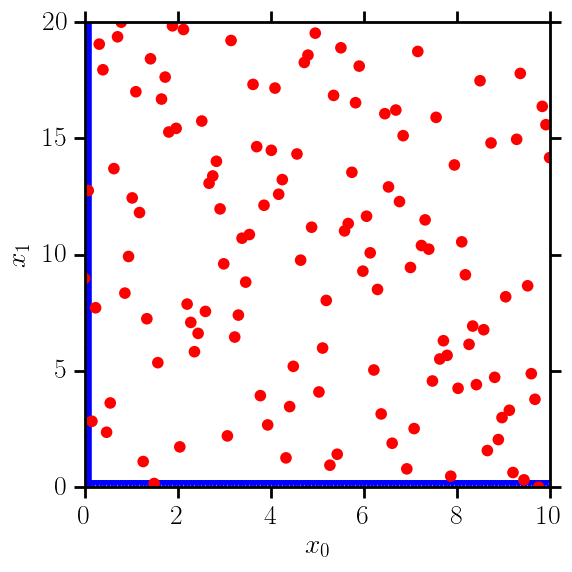

In [197]:
# Make 2d latin hypercube points
Ndata = 128
limits = np.array([[0, 10], [0, 20]])
points = gpr.latin_hypercube(Ndata, limits)

# ******* plot data *******
fig = plt.figure(figsize=(6, 6))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(111)

# for p in points[:, 0]:
#     axes.axvline(p, c='grey', lw=1)

# for p in points[:, 1]:
#     axes.axhline(p, c='grey', lw=1)
    
axes.scatter(min(points[:, 0])+0.0*points[:, 0], points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)
axes.scatter(points[:, 0], min(points[:, 1])+0.0*points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$x_0$')
axes.set_ylabel(r'$x_1$')

In [198]:
params = points

# Generate data
def func(x, y):
    return 0.1*x*np.sin(x) + 0.02*y**2

data = np.array([func(params[i, 0], params[i, 1]) for i in range(len(params))])

In [208]:
np.mean(data), np.std(data), np.min(data), np.max(data)

(2.752848383122676,
 2.3698925654467029,
 -0.42822159799142878,
 8.055789132833679)

In [199]:
from george import kernels

In [209]:
# sigma_f = 10.0
# sigma_n = 1.0e-6
# l0 = 3
# l1 = 10
# hyperparams = np.array([sigma_f, sigma_n, l0, l1])

sigma_f = 3.0
sigma_n = 1.0e-6
l0 = 3
l1 = 10
hyperparams = np.array([sigma_f, sigma_n, l0, l1])

# sigma_f = 7.12448529e+00
# sigma_n = 2.56781833e-04
# l0 = 3.69760330e+00
# l1 = 1.80868773e+01
# hyperparams = np.array([sigma_f, sigma_n, l0, l1])

# sigma_f = 10.0
# sigma_n = 1.0e-4
# l0 = 4.0
# l1 = 15.0
# hyperparams = np.array([sigma_f, sigma_n, l0, l1])

k = sigma_f**2*kernels.ExpSquaredKernel([l0**2, l1**2], ndim=2) + kernels.WhiteKernel(sigma_n**2, ndim=2)

###### Evaluate and compare to Ben's version ########

# value expects arrays x1, x2 each with shape (npoints, ndim) to evaluate the kernel npoints times
x1 = np.array([4, 1])
x2 = np.array([4, 1])
print k.value(np.array([x1]), np.array([x2]))[0, 0]
print gpr.squared_exponential_covariance(x1, x2, hyperparams)

x1 = np.array([3, 6])
x2 = np.array([4, 1])
print k.value(np.array([x1]), np.array([x2]))[0, 0]
print gpr.squared_exponential_covariance(x1, x2, hyperparams)

9.0
9.0
7.51325671153
7.51325671153


In [210]:
# This is reordered from Ben's version
k.pars**0.5, np.exp(k.vector)**0.5, k.vector

(array([  3.00000000e+00,   3.00000000e+00,   1.00000000e+01,
          1.00000000e-06]),
 array([  3.00000000e+00,   3.00000000e+00,   1.00000000e+01,
          1.00000000e-06]),
 array([  2.19722458,   2.19722458,   4.60517019, -27.63102112]))

In [211]:
# Set up the Gaussian process.
gp = george.GP(k)

# You need to compute the GP once before starting the optimization.
gp.compute(params)

gp.kernel.pars, np.exp(gp.kernel.vector), gp.kernel.vector, gp.kernel, np.exp(gp.kernel[:])**0.5

(array([  9.00000000e+00,   9.00000000e+00,   1.00000000e+02,
          1.00000000e-12]),
 array([  9.00000000e+00,   9.00000000e+00,   1.00000000e+02,
          1.00000000e-12]),
 array([  2.19722458,   2.19722458,   4.60517019, -27.63102112]),
 ConstantKernel(9.0, ndim=2) * ExpSquaredKernel(9.0, 100.0, ndim=2) + WhiteKernel(1e-12, ndim=2),
 array([  3.00000000e+00,   3.00000000e+00,   1.00000000e+01,
          1.00000000e-06]))

In [212]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    ll = gp.lnlikelihood(data, quiet=True)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    return -gp.grad_lnlikelihood(data, quiet=True)

# Print the initial ln-likelihood.
print(gp.lnlikelihood(data))

# Run the optimization routine.
p0 = gp.kernel.vector
results = op.minimize(nll, p0, jac=grad_nll)
#results = op.minimize(nll, p0)

# Update the kernel and print the final log-likelihood.
gp.kernel[:] = results.x
print(gp.lnlikelihood(data))
print(gp.kernel.vector)
print(gp.kernel.pars**0.5)

777.028315157
-1.65110957892e+14
[  3.64171185   2.61628846   5.69670129 -27.9727654 ]
[  6.17714336e+00   3.69930228e+00   1.72592917e+01   8.42929341e-07]


In [213]:
gp.kernel, gp.kernel.pars**0.5,  gp.kernel[:]

(ConstantKernel(38.1571001159, ndim=2) * ExpSquaredKernel(13.6848373283, 297.883148269, ndim=2) + WhiteKernel(7.10529874106e-13, ndim=2),
 array([  6.17714336e+00,   3.69930228e+00,   1.72592917e+01,
          8.42929341e-07]),
 array([  3.64171185,   2.61628846,   5.69670129, -27.9727654 ]))

In [214]:
np.exp(20)**0.5

22026.465794806718

In [216]:
xgrid = np.arange(0, 10, 0.1)
ygrid = np.arange(0, 10, 0.1)
X, Y = np.meshgrid(xgrid, ygrid)
Z = np.array([[nll(np.array([np.log(6.17**2), x1, y1, np.log(8.4e-7**2)])) for x1 in xgrid] for y1 in ygrid])

In [217]:
Z.min()

3278.597269219104

<a list of 0 text.Text objects>

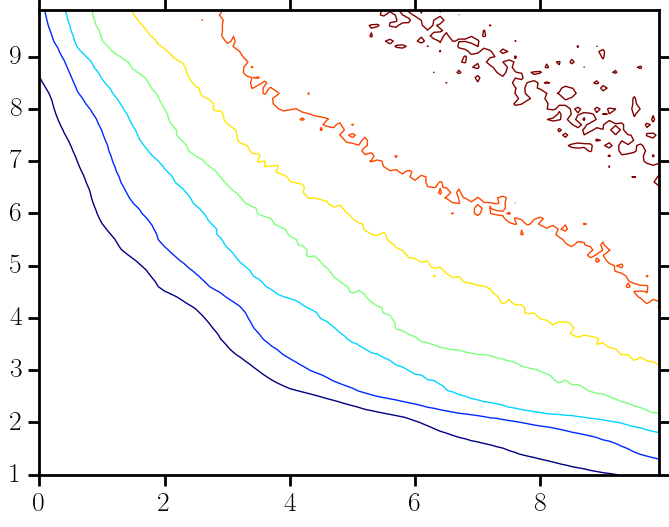

In [222]:
levels = Z.min() + np.arange(0, 100, 10)

fig, axes = plt.subplots(figsize=(8, 6))
axes.contour(X, Y, Z)
axes.contour(X, Y, Z, levels)
axes.clabel(CS, inline=1, fontsize=10)
#axes.plot(np.log10(hyperparams_opt[0]), np.log10(hyperparams_opt[2]), 'ro', markersize=5)
#axes.set_xlabel(r'$\log(\sigma_f)$')
#axes.set_ylabel(r'$\log(l_0)$')

# Compare results with Ben's version

In [40]:
gpset_ben = gpr.GaussianProcessSet(params, data, gpr.squared_exponential_covariance)
hyperparams_opt = gpset_ben.optimize(np.log10(hyperparams))
print hyperparams_opt

[  9.98250364e+00   1.00000000e-06   3.94354154e+00   1.46433437e+01]


In [293]:
# Set up the Gaussian process.
gp = george.GP(k)

# Pre-compute the factorization of the matrix.
gp.compute(params)

print gp.solver.log_determinant
print gp._const
print(gp.lnlikelihood(data))

-111.493913266
-3.06510949197
-5.17630031401


In [264]:
gp.solver = gp.solver_type(gp.kernel)
gp.solver.compute(gp._x, 1.25e-12)
print gp.solver.log_determinant
print -0.5 * (len(gp._x) * np.log(2 * np.pi) + gp.solver.log_determinant)

-111.493913266
-3.06510949197


In [265]:
# Ben's version
gp_ben = gpr.GaussianProcess(params, data, gpr.squared_exponential_covariance, hyperparams)

Kdet = np.linalg.det(gp_ben.K)
print np.log(Kdet)
print - 0.5*np.log(Kdet) - 0.5*gp_ben.nparams*np.log(2.0*np.pi)
print gp_ben.ln_like()

-111.493913266
-3.06510949197
-5.17630031401


In [247]:
gp_ben.ln_like() + (-101.449 - 123.69)

-163.67403023077955

In [166]:
gp_ben.K - gp.get_matrix(params)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

-365.008362378


123.69211506365346

In [87]:
# k.vector is the natural log of k.pars
k.pars, k.vector, k.vector_gradient, k.value

(array([  4.,  25.,   9.]),
 array([ 1.38629436,  3.21887582,  2.19722458]),
 array([  4.,  25.,   9.]),
 <bound method Product.value of ConstantKernel(4.0, ndim=2) * ExpSquaredKernel(25.0, 9.0, ndim=2)>)

In [ ]:
gp = george.GP(k)

In [ ]:

# Construct Gaussian process
hyperparams = np.array([2.0, 0.01, 3.0, 10.0])
gp = GaussianProcess(params, data, squared_exponential_covariance, hyperparams)
gp.ln_like()

In [104]:

# Generate some fake noisy data.
x = 10 * np.sort(np.random.rand(10))
yerr = 0.2 * np.ones_like(x)
y = np.sin(x) + yerr * np.random.randn(len(x))

In [106]:
y

array([ 0.16197804,  0.42637785,  1.19154404, -0.62262689,  0.02915746,
        0.22761052,  0.99187308,  0.615642  ,  0.46074066,  0.04649401])

In [105]:
import george
from george.kernels import ExpSquaredKernel

# Set up the Gaussian process.
kernel = ExpSquaredKernel(1.0)
gp = george.GP(kernel)

# Pre-compute the factorization of the matrix.
gp.compute(x, yerr)

# Compute the log likelihood.
print(gp.lnlikelihood(y))

-8.72707182391


In [30]:
x, y, yerr

(array([ 1.86073669,  2.55304122,  3.98995017,  5.74472886,  6.05757274,
         6.97826308,  7.27597665,  7.96734789,  9.66766445,  9.78299226]),
 array([ 1.0043587 ,  0.8718717 , -0.77404884, -0.78063968, -0.26907665,
         0.77712772,  0.97589495,  0.82002823, -0.07222397, -0.45620101]),
 array([ 0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2]))

In [31]:
t = np.linspace(0, 10, 500)
mu, cov = gp.predict(y, t)
std = np.sqrt(np.diag(cov))

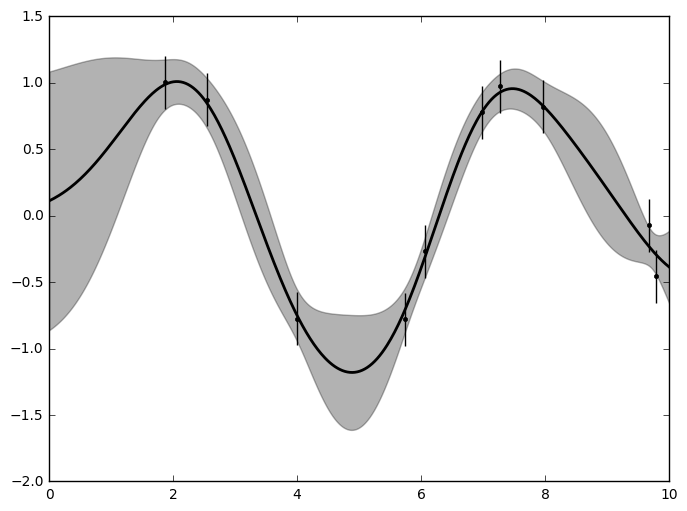

In [32]:
fig, axes = plt.subplots(1, figsize=(8, 6))
axes.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
axes.plot(t, mu, ls='-', c='k', lw=2)
axes.fill_between(t, mu-std, mu+std, color='k', alpha=0.3)

# Test George with correlated noise example

In [33]:
from __future__ import division, print_function

import emcee
import corner
import numpy as np
import matplotlib.pyplot as pl

import george
from george import kernels

In [8]:
def model(params, t):
    amp, loc, sig2 = params
    return amp * np.exp(-0.5 * (t - loc) ** 2 / sig2)


def lnprior_base(p):
    amp, loc, sig2 = p
    if not -10 < amp < 10:
        return -np.inf
    if not -5 < loc < 5:
        return -np.inf
    if not 0 < sig2 < 3.0:
        return -np.inf
    return 0.0


def lnlike_ind(p, t, y, invar):
    m = model(p[2:], t) + p[0] * t + p[1]
    return -0.5 * np.sum((y - m) ** 2 * invar)


def lnprior_ind(p):
    m, b = p[:2]
    if not -10 < m < 10:
        return -np.inf
    if not -10 < b < 10:
        return -np.inf
    return lnprior_base(p[2:])


def lnprob_ind(p, t, y, invar):
    lp = lnprior_ind(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_ind(p, t, y, invar)


def fit_ind(initial, data, nwalkers=32):
    ndim = len(initial)
    p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_ind, args=data)

    print("Running burn-in")
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)

    return sampler


def lnlike_gp(p, t, y, yerr):
    a, tau = np.exp(p[:2])
    gp = george.GP(a * kernels.Matern32Kernel(tau))
    gp.compute(t, yerr)
    return gp.lnlikelihood(y - model(p[2:], t))


def lnprior_gp(p):
    lna, lntau = p[:2]
    if not -5 < lna < 5:
        return -np.inf
    if not -5 < lntau < 5:
        return -np.inf
    return lnprior_base(p[2:])


def lnprob_gp(p, t, y, yerr):
    lp = lnprior_gp(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_gp(p, t, y, yerr)


def fit_gp(initial, data, nwalkers=32):
    ndim = len(initial)
    p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gp, args=data)

    print("Running burn-in")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running second burn-in")
    p = p0[np.argmax(lnp)]
    p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)

    return sampler


def generate_data(params, N, rng=(-5, 5)):
    gp = george.GP(0.1 * kernels.ExpSquaredKernel(3.3))
    t = rng[0] + np.diff(rng) * np.sort(np.random.rand(N))
    y = gp.sample(t)
    y += model(params, t)
    yerr = 0.05 + 0.05 * np.random.rand(N)
    y += yerr * np.random.randn(N)
    return t, y, yerr

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


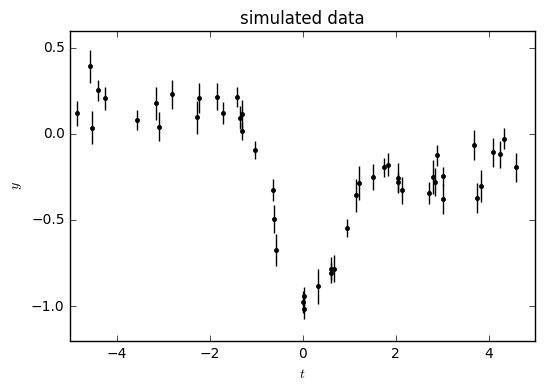

In [9]:
# Generate data
np.random.seed(1234)
truth = [-1.0, 0.1, 0.4]
t, y, yerr = generate_data(truth, 50)
pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.title("simulated data")

Fitting independent
Running burn-in
Running production
Making plots


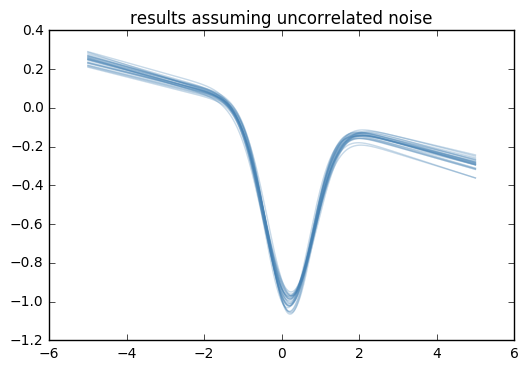

In [10]:
# Fit assuming independent.
print("Fitting independent")
data = (t, y, 1.0 / yerr ** 2)
truth_ind = [0.0, 0.0] + truth
sampler = fit_ind(truth_ind, data)

# Plot the samples in data space.
print("Making plots")
samples = sampler.flatchain
x = np.linspace(-5, 5, 500)
for s in samples[np.random.randint(len(samples), size=24)]:
    pl.plot(x, model(s[2:], x)+s[0]*x+s[1], color="#4682b4", alpha=0.3)
pl.title("results assuming uncorrelated noise")

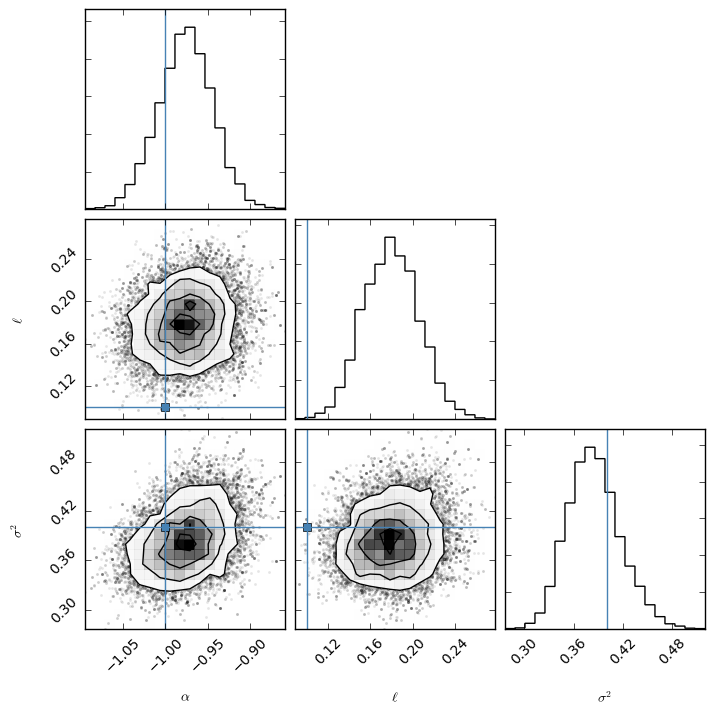

In [11]:
# Make the corner plot.
labels = [r"$\alpha$", r"$\ell$", r"$\sigma^2$"]
fig = corner.corner(samples[:, 2:], truths=truth, labels=labels)

Fitting GP
Running burn-in
Running second burn-in
Running production
Making plots


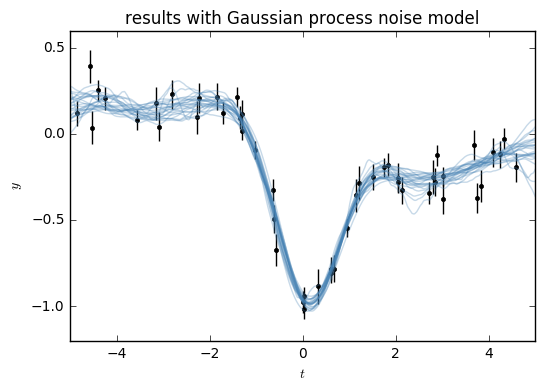

In [12]:
# Fit assuming GP.
print("Fitting GP")
data = (t, y, yerr)
truth_gp = [0.0, 0.0] + truth
sampler = fit_gp(truth_gp, data)

# Plot the samples in data space.
print("Making plots")
samples = sampler.flatchain
x = np.linspace(-5, 5, 500)
pl.figure()
pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
for s in samples[np.random.randint(len(samples), size=24)]:
    gp = george.GP(np.exp(s[0]) * kernels.Matern32Kernel(np.exp(s[1])))
    gp.compute(t, yerr)
    m = gp.sample_conditional(y - model(s[2:], t), x) + model(s[2:], x)
    pl.plot(x, m, color="#4682b4", alpha=0.3)
pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.title("results with Gaussian process noise model")

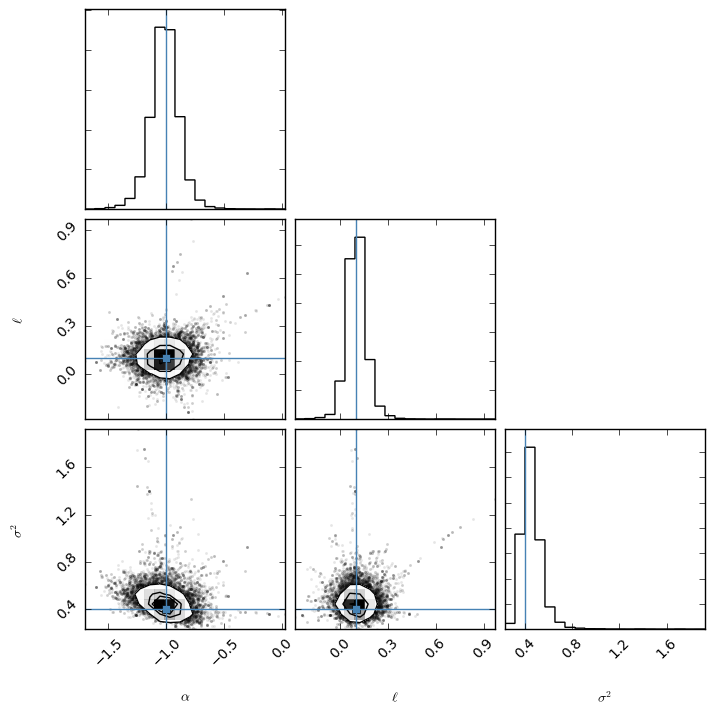

In [35]:
# Make the corner plot.
fig = corner.corner(samples[:, 2:], truths=truth, labels=labels)